Notebook take from: https://github.com/Phil26AT/

Our datatset given to the algorithm for visual slam

In [ ]:
!git clone --quiet --recursive https://github.com/cvg/Hierarchical-Localization/
%cd /content/Hierarchical-Localization
!pip install -e .
!pip install --upgrade --quiet plotly

import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

/content/Hierarchical-Localization
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/Hierarchical-Localization
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.0/612.0 KB 58.2 MB/s eta 0:00:00
  Running setup.py develop for hloc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 66.4 MB/s eta 0:00:00


# Setup
Here we define some output paths. We will use SuperPoint local features with the SuperGlue matcher, but it's easy to switch to other features like SIFT or R2D2.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

path_to_images_dir = "/content/drive/MyDrive/Master-Thesis-Structure-from-Motion/street_1/images"
path_to_output_dir = "/content/drive/MyDrive/Master-Thesis-Structure-from-Motion/street_1/output"

images = Path(path_to_images_dir)
outputs = Path(path_to_output_dir)
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3D mapping
First we list the images used for mapping. These are all day-time shots of Sacre Coeur.

40 mapping images


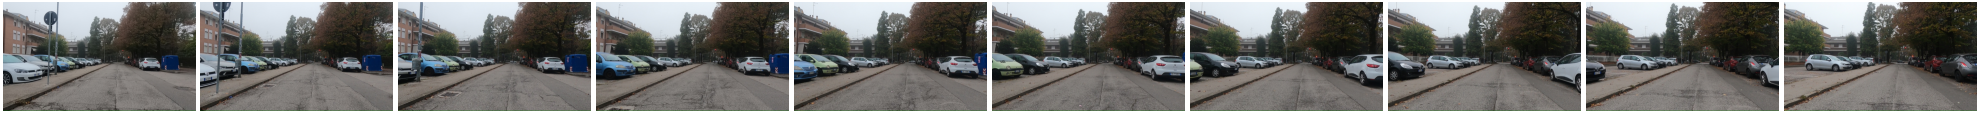

In [ ]:
references = [str(p.relative_to(images)) for p in sorted(images.iterdir())]
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references[:10]], dpi=25)

Then we extract features and match them across image pairs. Since we deal with few images, we simply match all pairs exhaustively. For larger scenes, we would use image retrieval, as demonstrated in the other notebooks.

In [ ]:
extract_features.main(feature_conf, images, image_list=references, feature_path=features)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2023/03/03 19:39:17 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


  0%|          | 0/40 [00:00<?, ?it/s]

[2023/03/03 19:40:20 hloc INFO] Finished exporting features.
[2023/03/03 19:40:20 hloc INFO] Found 780 pairs.
[2023/03/03 19:40:20 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/780 [00:00<?, ?it/s]

[2023/03/03 19:42:54 hloc INFO] Finished exporting matches.


*The* we run incremental Structure-from-Motion and display the reconstructed 3D model.

In [ ]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping")
fig.show()

[2023/03/03 19:43:15 hloc INFO] Creating an empty database...
[2023/03/03 19:43:15 hloc INFO] Importing images into the database...
[2023/03/03 19:43:17 hloc INFO] Importing features into the database...


  0%|          | 0/40 [00:00<?, ?it/s]

[2023/03/03 19:43:17 hloc INFO] Importing matches into the database...


  0%|          | 0/780 [00:00<?, ?it/s]

[2023/03/03 19:43:57 hloc INFO] Performing geometric verification of the matches...
[2023/03/03 19:49:11 hloc INFO] Running 3D reconstruction...
[2023/03/03 19:53:42 hloc INFO] Reconstructed 1 model(s).
[2023/03/03 19:53:42 hloc INFO] Largest model is #0 with 40 images.
[2023/03/03 19:53:42 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 40
	num_cameras = 40
	num_points3D = 9904
	num_observations = 41295
	mean_track_length = 4.16953
	mean_observations_per_image = 1032.38
	mean_reprojection_error = 1.22783
	num_input_images = 40


We also visualize which keypoints were triangulated into the 3D model.

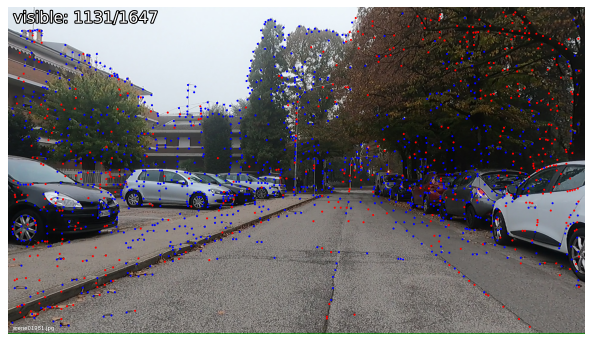

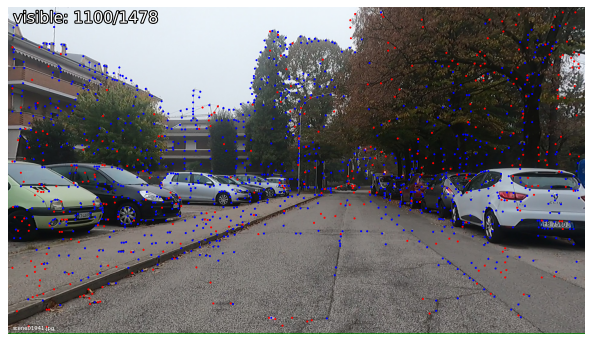

In [ ]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=2)

# Localization
Now that we have a 3D map of the scene, we can localize any image. To demonstrate this, we download [a night-time image from Wikimedia](https://commons.wikimedia.org/wiki/File:Paris_-_Basilique_du_Sacr%C3%A9_Coeur,_Montmartre_-_panoramio.jpg).

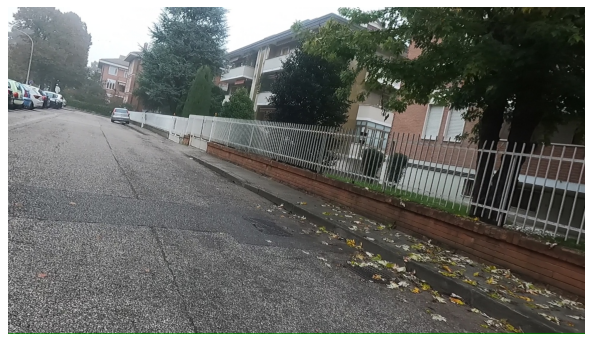

In [ ]:
image_query = "/content/drive/MyDrive/Master-Thesis-Structure-from-Motion/street_1/images_new/scene02641.jpg"

plot_images([read_image(image_query)], dpi=75)

Again, we extract features for the query and match them exhaustively with all mapping images that were successfully reconstructed.

In [ ]:
references_registered = [model.images[i].name for i in model.reg_image_ids()]
extract_features.main(feature_conf, images, image_list=[image_query], feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=[image_query], ref_list=references_registered)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True);

[2023/03/03 19:55:30 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


  0%|          | 0/1 [00:00<?, ?it/s]

[2023/03/03 19:55:31 hloc INFO] Finished exporting features.
[2023/03/03 19:55:31 hloc INFO] Found 40 pairs.
[2023/03/03 19:55:31 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning:

This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



  0%|          | 0/40 [00:00<?, ?it/s]

[2023/03/03 19:55:39 hloc INFO] Finished exporting matches.


We read the EXIF data of the query to infer a rough initial estimate of camera parameters like the focal length. Then we estimate the absolute camera pose using PnP+RANSAC and refine the camera parameters.

found 92/994 inlier correspondences.


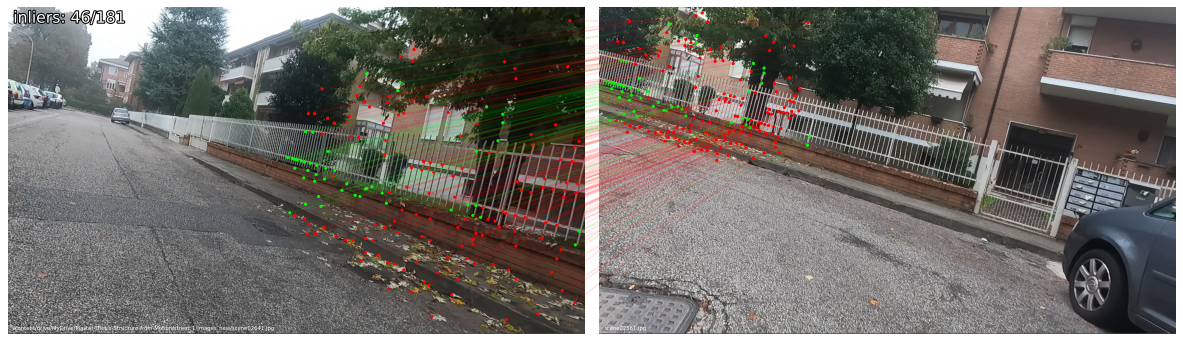

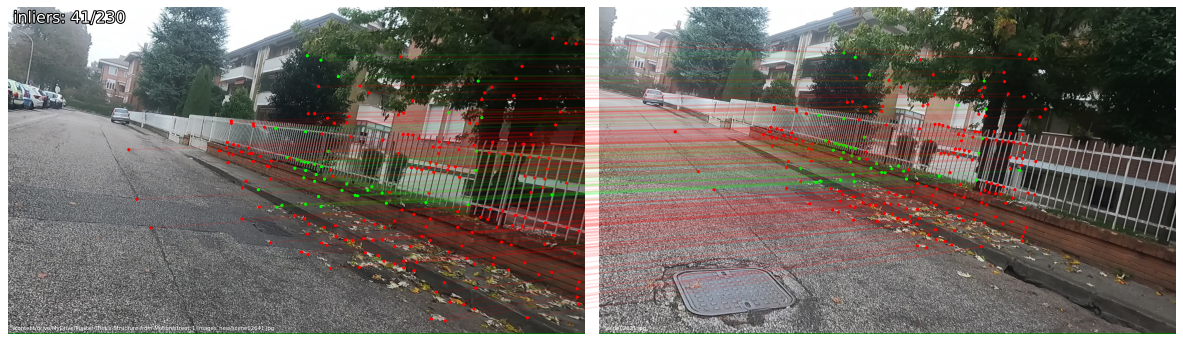

In [ ]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(image_query)
ref_ids = [model.find_image_with_name(n).image_id for n in references_registered]
conf = {
    'estimation': {'ransac': {'max_error': 12}},
    'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, image_query, camera, ref_ids, features, matches)

print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, image_query, log, model)

We visualize the correspondences between the query images a few mapping images. We can also visualize the estimated camera pose in the 3D map.

In [ ]:
pose = pycolmap.Image(tvec=ret['tvec'], qvec=ret['qvec'])
viz_3d.plot_camera_colmap(fig, pose, camera, color='rgba(0,255,0,0.5)', name=image_query)
fig.show()